In [38]:
import pandas as pd
import pycaret
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pycaret.classification import *
from imblearn.over_sampling import SMOTE

In [28]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df

,timestamp,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1052265600000000000,1,174.144444,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1052352000000000000,1,156.247222,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1052438400000000000,1,124.135417,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1052524800000000000,1,134.961806,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1052611200000000000,1,99.439583,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1086480000000000000,9,162.295833,13,0,1,1.0,2.0,2.0,1,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,1086566400000000000,9,224.508333,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,1086652800000000000,9,202.056250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,1086739200000000000,9,168.656250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [29]:
df['category_madrs'].value_counts()

0    201
1    188
Name: category_madrs, dtype: int64

In [30]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.user_id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.user_id.isin(users_train)], data[data.user_id.isin(users_test)]

In [31]:
train_data, test_data = train_test_split_per_user(df)

fold_groups = train_data.user_id
train_data = train_data.drop(columns=['user_id'])
test_data = test_data.drop(columns=['user_id'])

In [33]:
#s = setup(data=train_data, target='category_madrs', session_id=123, fold_strategy='groupkfold', fold=5,  fold_groups=fold_groups, test_data=test_data, normalize=True)
s = setup(data=train_data, target='category_madrs', session_id=123, test_data=test_data, normalize=True)

,Description,Value
0,Session id,123
1,Target,category_madrs
2,Target type,Binary
3,Original data shape,"(389, 23)"
4,Transformed data shape,"(389, 23)"
5,Transformed train set shape,"(264, 23)"
6,Transformed test set shape,"(125, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


In [34]:
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9962,1.0000,1.0000,0.9917,0.9957,0.9922,0.9925,0.1400
ada,Ada Boost Classifier,0.9923,1.0000,1.0000,0.9846,0.9917,0.9846,0.9856,0.0250
catboost,CatBoost Classifier,0.9667,1.0000,1.0000,0.9571,0.9727,0.9372,0.9478,0.9120
rf,Random Forest Classifier,0.9593,1.0000,1.0000,0.9522,0.9686,0.9244,0.9373,0.0440
et,Extra Trees Classifier,0.9577,1.0000,1.0000,0.9500,0.9667,0.9235,0.9365,0.0380
svm,SVM - Linear Kernel,0.9425,0.0000,0.9818,0.9435,0.9541,0.8959,0.8991,0.0100
lda,Linear Discriminant Analysis,0.9349,0.9091,1.0000,0.9256,0.9508,0.8849,0.8854,0.0110
ridge,Ridge Classifier,0.9053,0.0000,1.0000,0.8947,0.9282,0.8328,0.8443,0.0100
lr,Logistic Regression,0.8942,0.9418,0.9909,0.8901,0.9194,0.8136,0.8271,0.3510
gbc,Gradient Boosting Classifier,0.9185,0.9133,0.9000,0.8522,0.8686,0.8244,0.8373,0.0250


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [35]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [36]:
predictions_df = predict_model(best, data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.2560,0.2844,0.2078,0.3333,0.2560,-0.4120,-0.4589


In [37]:
from sklearn.metrics import f1_score

f1 = f1_score(predictions_df['category_madrs'], predictions_df['Label'])

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.2560


In [13]:
# Extracting X_test (features) - this includes all columns except the label and prediction columns
X_test = predictions.drop(columns=['Label', 'Score'])

# Extracting y_test (true labels)
y_test = predictions['category_madrs']  # Adjust this to your actual target column name

# Extracting y_pred (predicted labels)
y_pred = predictions['Label']

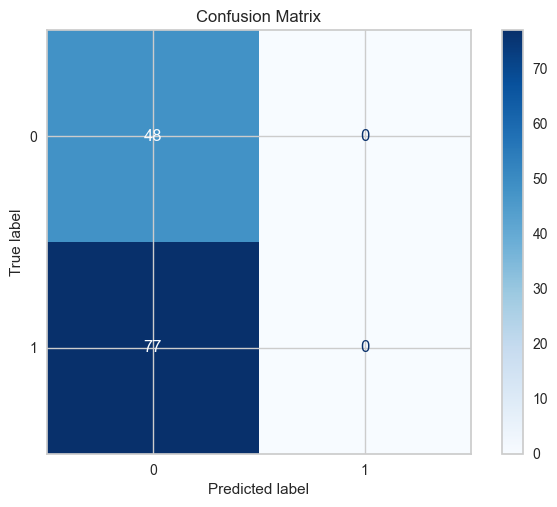

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred.to_csv('../data/depresjon/predictions/depresjon_pred_generic.csv', index=False)
X_test.to_csv('../data/depresjon/predictions/depresjon_X_test_generic.csv', index=False)
y_test.to_csv('../data/depresjon/predictions/depresjon_y_test_generic.csv', index=False)